<a href="https://colab.research.google.com/github/ameasure/autocoding-class/blob/master/FastAI_1_0_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the Libraries and Data

1.   pytorch (a library for building neural networks)
2.   fastai (a library built on top of pytorch)
3.   spacy english language model
4.   msha.xlsx data (the MSHA data we will classify)
5.   xlrd (a library for reading excel files)

In [1]:
#!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
#!pip install fastai
!python -m spacy download en
!wget --no-clobber 'https://github.com/ameasure/autocoding-class/raw/master/msha.xlsx'
!pip install xlrd

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████                    | 218.0MB 2.3MB/s eta 0:02:40
ERROR: Operation cancelled by user
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
^C
--2019-06-12 20:36:39--  https://github.com/ameasure/autocoding-class/raw/master/msha.xlsx
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ameasure/autocoding-class/master/msha.xlsx [following]
--2019-06-12 20:36:40--  https://raw.githubusercontent.com/ameasure/autocoding-class/master/msha.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)...

# Split the MSHA Data into Training and Validation

In [2]:
import pandas as pd

df = pd.read_excel('msha.xlsx')
df['ACCIDENT_YEAR'] = df['ACCIDENT_DT'].apply(lambda x: x.year)
df['ACCIDENT_YEAR'].value_counts()
df_train = df[df['ACCIDENT_YEAR'].isin([2010, 2011])].copy()
df_valid = df[df['ACCIDENT_YEAR'] == 2012].copy()
print('training rows:', len(df_train))
print('validation rows:', len(df_valid))

training rows: 18681
validation rows: 9032


Convert the labels to 1-hot arrays.

In [0]:
from sklearn.preprocessing import LabelEncoder

labeler = LabelEncoder().fit(df['INJ_BODY_PART'])
df_train['LABEL'] = labeler.transform(df_train['INJ_BODY_PART'])
df_valid['LABEL'] = labeler.transform(df_valid['INJ_BODY_PART'])

# Recipe
Now we will finetune a pretrained language model to build a state of the art text classifier. This involves the following steps:

1.   Load the weights of a pre-trained language model, i.e. a model trained to predict the next word in a sequence of words on a huge collection of text. We don't want to do this pretraining ourselves because it takes a long time of time.
2.   Finetune the language model to some of the language data in our dataset. This can include all the data currently available since this is an unsupervised process, i.e. the model only sees the text we are working with, not the codes that were assigned.
3.   Remove the output layer of our language model and put a classifier layer on top.
4.   Finetune the new model to our classification task.

Each finetune step consists of 5 smaller steps:
1. Unfreeze only the last layer.
2. Find a good learning rate.
3. Train the last layer for one epoch (to get a better missing-word embedding vector)
4. Unfreeze the rest of the layers
5. Train the rest of the layers, normally with lower learning rates than the last layer




# Load the pretrained model weights

First we create a directory called 'models', and save the weights there.

In [0]:
import os

if not os.path.exists('models'):
  os.mkdir('models')

Download the pretrained models

In [0]:
from fastai.core import download_url

download_url('http://files.fast.ai/models/wt103_v1/lstm_wt103.pth', 'models/lstm_wt103.pth')
download_url('http://files.fast.ai/models/wt103_v1/itos_wt103.pkl', 'models/itos_wt103.pkl')

Now we load the weights into our model and take a look

In [41]:
from fastai.text.learner import language_model_learner
from fastai.text.models import AWD_LSTM

language_model = language_model_learner(lm_data, 
                                        arch=AWD_LSTM,
                                        pretrained_fnames=['lstm_wt103', 'itos_wt103'], 
                                        drop_mult=0.5)
print(language_model.model)

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(7149, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(7149, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=7149, bias=True)
    (output_dp): RNNDropout()
  )
)


As you can see, our model consists of five main layers:
1. An embedding layer which maps 7148 word indexes to vectors
2. An LSTM layer which maps 400 dim word vectors to 1150 dim contextual vectors
3. A second LSTM layer operating on the output of the first LSTM
4. A third LSTM layer operaton on the output of the second LSTM
5. A linear output layer generating predicted probabilities for each of the 7148 words in our vocabulary.

# Finetune the language model on some of our own text

We start by preparing a language model "DataBunch" from our CSV files. A "DataBunch" contains tokenized text that has been mapped to numbers, each representing a word in the text.

In [0]:
from fastai.text.data import TextLMDataBunch

lm_data = TextLMDataBunch.from_df('./', 
                                  text_cols=['NARRATIVE'],
                                  train_df=df_train,
                                  valid_df=df_valid)

Now we load the model and finetune it to on our data.

In [0]:
from fastai.text.learner import language_model_learner
from fastai.text.models import AWD_LSTM

language_model = language_model_learner(lm_data, 
                                        arch=AWD_LSTM,
                                        pretrained_fnames=['lstm_wt103', 'itos_wt103'], 
                                        drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


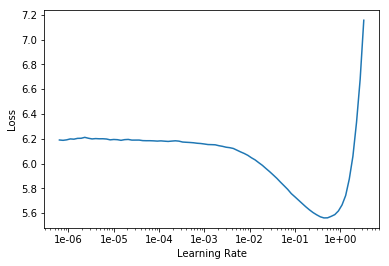

In [54]:
language_model.lr_find()
language_model.recorder.plot()

In [56]:
language_model.freeze_to(-1)
language_model.fit_one_cycle(cyc_len=1, max_lr=7e-1)


epoch,train_loss,valid_loss,accuracy,time
0,7.190481,5.611742,0.173723,00:43


In [8]:
language_model.unfreeze()
language_model.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.537589,3.363298,0.360719,00:53
1,3.293390,3.181091,0.381548,00:52
2,3.150813,3.092407,0.391696,00:51
3,3.045129,3.056403,0.396010,00:52
4,3.004687,3.049335,0.397088,00:52


In [0]:
language_model.save_encoder('ft_enc')

# Fit the model to our classification task

In [0]:
#!wget --no-clobber https://www.dropbox.com/s/45i662vci7ja6vv/ft_enc.pth?dl=0
#!mv ft_enc.pth?dl=0 models/ft_enc.pth

In [0]:
from fastai.text import TextClasDataBunch

data_clas = TextClasDataBunch.from_df('./', 
                                      train_df = df_train, 
                                      valid_df = df_valid,
                                      text_cols=['NARRATIVE'],
                                      label_cols=['LABEL'],
                                      classes=sorted(df_train['LABEL'].unique()),
                                      vocab=lm_data.train_ds.vocab)

In [12]:
data_clas.show_batch()

text,target
"xxbos xxup ee xxup was xxup removing xxup wheel xxup chocks w / l xxup hand xxup out xxup from xxup under l xxup front xxup wheel xxup of xxup truck . xxup as xxup he xxup pulled xxup rope & xxup twisted xxup chocks xxup for xxup removal , xxup felt xxup pain xxup in xxup top xxup of l xxup hand . xxup ee xxup refused xxup medical",45
xxbos xxup employee xxup was xxup steam xxup cleaning a xxup radiator xxup of a xxup dozer . xxup employee xxup stopped xxup to xxup reposition xxup his xxup footing xxup and xxup then xxup activated xxup his xxup wand xxup spraying xxup himself xxup in xxup the xxup left xxup thumb xxup causing a xxup puncture xxup wound . xxup employee xxup was xxup taken xxup to xxup summersville,19
"xxbos xxup after xxup employee xxup pulled a xxup core xxup tube xxup out xxup from xxup the xxup drill , xxup he xxup was xxup walking xxup over xxup to xxup unload xxup the xxup core xxup from xxup the xxup tube xxup at xxup the xxup tube xxup rack xxup and xxup he xxup tripped xxup on xxup the xxup helper xxup 's xxup deck xxup causing xxup",19
"xxbos xxup employee xxup was xxup operating xxup scissor xxup lift # 8 , xxup he xxup needed xxup to xxup adjust xxup his xxup seat . xxup when xxup he xxup pulled xxup the xxup lever xxup to xxup adjust xxup his xxup seat xxup to xxup move xxup it xxup backwards xxup his xxup ring xxup finger xxup on xxup his xxup left xxup hand xxup got xxup",16
"xxbos xxmaj on 11 / 17 , the xxup ee struck his head on an overhead structure . xxup ee reported the incident to mgmt on 11 / 18 . xxup ee was seen by the medical staff & xxup rtw w / o restrictions . xxmaj on 11 / 25 , xxup ee reported to the medical facility complaining of dizziness , pain & tingling in his left arm",31


In [0]:
from fastai.text.learner import text_classifier_learner

learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

We can use the `lr_find()` tool to find a good learning rate to use. It shows how rapidly the loss changes at various learning rates. You want the learning rate that gives the steepest drop in loss. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


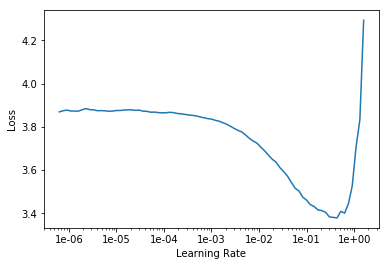

In [14]:
learn.lr_find()
learn.recorder.plot()

We now fit our classifier to the data, first only the last layer, then unfreezing the lower layers until the whole model is being trained.

In [15]:
# Fit just the last layer of the model
learn.fit_one_cycle(1, 1e-1)
# Now unfreeze the last 2 layers and fit those
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.320218,1.963870,0.455492,00:25


epoch,train_loss,valid_loss,accuracy,time
0,1.747584,1.480519,0.582595,00:32


In [16]:
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.652349,1.367127,0.613043,00:32


In [17]:
# Unfreeze all layers and fit these
learn.unfreeze()
learn.fit_one_cycle(5, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.519569,1.226246,0.663308,00:51
1,1.304789,0.979625,0.729960,00:57
2,1.114360,0.876866,0.761072,00:58
3,1.066380,0.850161,0.774358,00:50
4,1.002598,0.830779,0.776129,00:53


In [18]:
learn.fit_one_cycle(5, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.000564,0.827363,0.779340,00:58
1,0.947996,0.786272,0.792516,00:50
2,0.893557,0.766798,0.797276,00:55
3,0.863382,0.757774,0.799823,00:59
4,0.855972,0.755832,0.799269,00:57


In [19]:
learn.fit_one_cycle(5, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.825764,0.756128,0.800487,00:55
1,0.838366,0.753300,0.803144,00:49
2,0.773045,0.831841,0.805802,00:59
3,0.760684,0.745844,0.807352,00:58
4,0.734557,0.740475,0.808237,00:57


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


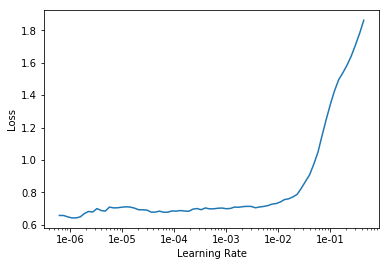

In [26]:
learn.lr_find()
learn.recorder.plot()

In [32]:
len(learn.layer_groups)

5

# Useful References:

*   [FastAI IMDB Notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb)
*   [FastAI Docs](https://docs.fast.ai/)


